# Notebook 3 - Feature Engineering

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 5
NUM_TREES = 10000
EARLY_STOP = 100
VERBOSE = False

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import time
import os
import pyarrow
import gc

# Model evaluation
from functools import partial
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import mutual_info_classif

# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# Plotting
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [3]:
def get_data():
    try:
        #
        original = pd.read_feather('../data/original.feather')
    except:
        # Get Original Data
        original = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz', header = None)

        # Fix columns
        original.columns = ['Elevation', 'Aspect', 'Slope',
               'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
               'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
               'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
               'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
               'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
               'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
               'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
               'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
               'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
               'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
               'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
               'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
               'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
               'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40',
               'Cover_Type']

        for col, dtype in original.dtypes.iteritems():
            if dtype.name.startswith('int'):
                original[col] = pd.to_numeric(original[col], downcast ='integer')
            elif dtype.name.startswith('float'):
                original[col] = pd.to_numeric(original[col], downcast ='float')
        
        if not os.path.isdir('../data'):
            os.mkdir('../data')
        original.to_feather('../data/original.feather')
    return original

In [4]:
%%time
original = get_data()

# Get feature columns
features = [x for x in original.columns if x not in ['Id','Cover_Type']]
wilderness_cols = [x for x in features if x.startswith('Wild')]
soil_cols = [x for x in features if x.startswith('Soil')]
binary_cols = [x for x in features if x.startswith('Soil') or x in wilderness_cols]
numerical_cols = [x for x in features if x not in binary_cols]

# Encoder
old_encoder = LabelEncoder()
original["Cover_Type"] = old_encoder.fit_transform(original["Cover_Type"])

# Data structures for summary scores
new_rows = list()
old_rows = list()

Wall time: 58 ms


# Scoring Features

In [5]:
# Scoring/Training Baseline Function
def train_cv(processing = None):
    
    print(f'\n{NUM_FOLDS}-fold Cross-Validation\n')
    
    # Store the holdout predictions
    oof_preds = np.zeros((original.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(original, original['Cover_Type'])):
        
        # Training and Validation Sets
        X_train = original[features].iloc[train_idx]
        X_valid = original[features].iloc[valid_idx]
        y_train = original['Cover_Type'].iloc[train_idx]
        y_valid = original['Cover_Type'].iloc[valid_idx]
        
        # Feature Engineering
        if processing:
            X_train = processing(X_train)
            X_valid = processing(X_valid)
            
        X_train, X_test, y_train, y_test = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42
        )
        
        # Create model
        start = time.time()
        model = XGBClassifier(
            n_estimators = NUM_TREES,
            booster = 'gbtree',
            tree_method = 'hist',
            eval_metric = 'mlogloss',
            random_state = RANDOM_SEED,
        )

        model.fit(
            X_train, y_train,
            eval_set = [(X_test, y_test)],
            early_stopping_rounds = EARLY_STOP,
            verbose = VERBOSE,
        )
        
        # validation predictions
        valid_preds = np.ravel(model.predict(X_valid))
        oof_preds[valid_idx] = valid_preds
        
        # fold auc score
        fold_acc = accuracy_score(y_valid, valid_preds)
        end = time.time()
        print(f'Fold {fold} Accuracy:  {round(fold_acc, 5)} in {round(end-start,2)}s.')
        scores[fold] = fold_acc
        times[fold] = end-start
        
        time.sleep(0.5)
        
    print("\nAverage Accuracy:", round(scores.mean(), 5))
    print("Worst Accuracy:", round(scores.min(), 5))
    print(f'Training Time: {round(times.sum(), 2)}s\n')
    
    # Plot confusion matrix
    fig, ax = plt.subplots(figsize = (8,6))
    cm = confusion_matrix(original['Cover_Type'], oof_preds, normalize = 'true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax = ax)
    plt.title("Confusion Matrix (% of Actual Labels)", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("Actual Labels", fontsize=14)
    plt.show()
    
    return scores.mean(), oof_preds

In [6]:
def train_original(processing = None):
    
    print('\nOriginal Train/Test Split')
    
    # Store the holdout predictions
    oof_preds = np.zeros((original.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    
    # Training and Validation Sets
    X_train = original[features].iloc[:11339]
    X_valid = original[features].iloc[11339:15119]
    X_test = original[features].iloc[15119:]
    
    y_train = original['Cover_Type'].iloc[:11339]
    y_valid = original['Cover_Type'].iloc[11339:15119]
    y_test = original['Cover_Type'].iloc[15119:]
    
    # Feature Engineering
    if processing:
        X_train = processing(X_train)
        X_valid = processing(X_valid)
        X_test = processing(X_test)
        
    # Create model
    start = time.time()
    model = XGBClassifier(
        booster = 'gbtree',
        tree_method = 'hist',
        eval_metric = 'mlogloss',
        random_state = RANDOM_SEED,
    )
    model.fit(
        X_train, y_train,
        eval_set = [(X_valid, y_valid)],
        early_stopping_rounds = EARLY_STOP,
        verbose = VERBOSE,
    )
        
    # validation and test predictions
    test_preds = np.ravel(model.predict(X_test))
    accuracy = accuracy_score(y_test, test_preds)
    end = time.time()        
    time.sleep(0.5)
    
    print("\nAccuracy:", round(accuracy, 5))
    print(f'Training Time: {round(end-start, 2)}s\n')
    
    # Plot confusion matrix
    fig, ax = plt.subplots(figsize = (8,6))
    cm = confusion_matrix(y_test, test_preds, normalize = 'true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax = ax)
    plt.title("Confusion Matrix (% of Actual Labels)", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("Actual Labels", fontsize=14)
    plt.show()
    
    return accuracy, test_preds

# General Feature Engineering

## 1. XGBoost Baseline


5-fold Cross-Validation

Fold 0 Accuracy:  0.96623 in 434.97s.
Fold 1 Accuracy:  0.96585 in 450.05s.
Fold 2 Accuracy:  0.9663 in 446.19s.
Fold 3 Accuracy:  0.9655 in 435.26s.
Fold 4 Accuracy:  0.96622 in 422.95s.

Average Accuracy: 0.96602
Worst Accuracy: 0.9655
Training Time: 2189.41s



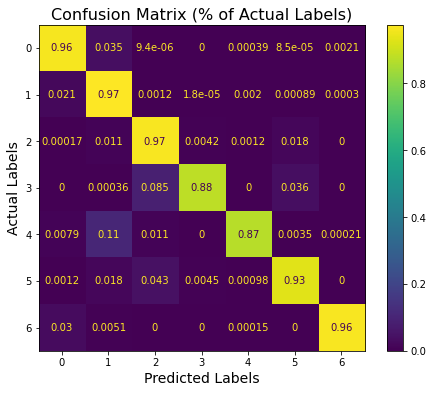

In [7]:
# Cross-validation Baseline
cv_score, oof_preds = train_cv()

new_rows.append((
    'Baseline', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))


Original Train/Test Split

Accuracy: 0.72417
Training Time: 2.17s



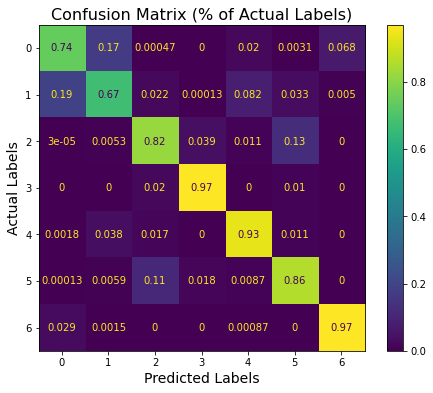

In [8]:
# Train/Test split
test_score, oof_preds = train_original()

old_rows.append((
    'Baseline', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 2. Fix Aspect Range

In [9]:
# Fix aspect
def fix_aspect(data):
    df = data.copy()
    df["Aspect"][df["Aspect"] < 0] += 360
    df["Aspect"][df["Aspect"] > 359] -= 360
    return df


5-fold Cross-Validation

Fold 0 Accuracy:  0.96636 in 403.79s.
Fold 1 Accuracy:  0.96564 in 409.4s.
Fold 2 Accuracy:  0.96702 in 399.06s.
Fold 3 Accuracy:  0.96567 in 403.92s.
Fold 4 Accuracy:  0.96651 in 436.85s.

Average Accuracy: 0.96624
Worst Accuracy: 0.96564
Training Time: 2053.03s



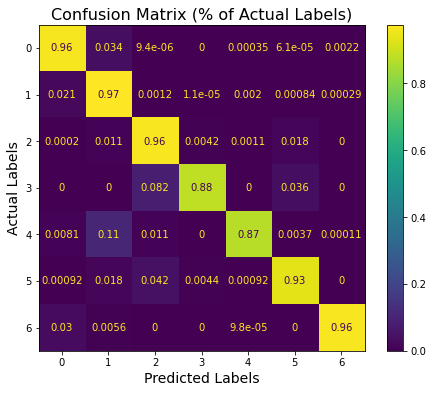

In [10]:
# Cross-validation
cv_score, oof_preds = train_cv(fix_aspect)

new_rows.append((
    'Fix_Aspect', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))


Original Train/Test Split

Accuracy: 0.71914
Training Time: 2.09s



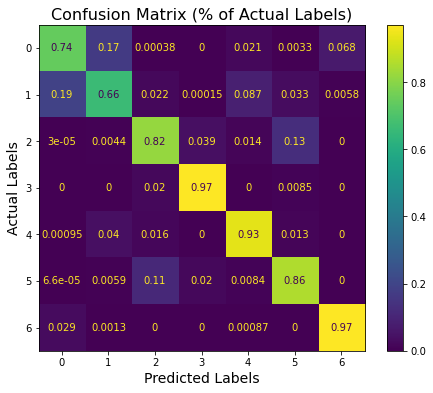

In [11]:
# Train/Test split
test_score, oof_preds = train_original(fix_aspect)

old_rows.append((
    'Fix_Aspect', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 3. Fix Hillshade Range

In [12]:
# Fix Hillshade
def fix_hillshade(data):
    df = data.copy()
    df.loc[df["Hillshade_9am"] < 0, "Hillshade_9am"] = 0
    df.loc[df["Hillshade_Noon"] < 0, "Hillshade_Noon"] = 0
    df.loc[df["Hillshade_3pm"] < 0, "Hillshade_3pm"] = 0
    df.loc[df["Hillshade_9am"] > 255, "Hillshade_9am"] = 255
    df.loc[df["Hillshade_Noon"] > 255, "Hillshade_Noon"] = 255
    df.loc[df["Hillshade_3pm"] > 255, "Hillshade_3pm"] = 255
    return df


5-fold Cross-Validation

Fold 0 Accuracy:  0.96623 in 415.7s.
Fold 1 Accuracy:  0.96585 in 391.27s.
Fold 2 Accuracy:  0.9663 in 395.78s.
Fold 3 Accuracy:  0.9655 in 397.52s.
Fold 4 Accuracy:  0.96622 in 401.7s.

Average Accuracy: 0.96602
Worst Accuracy: 0.9655
Training Time: 2001.97s



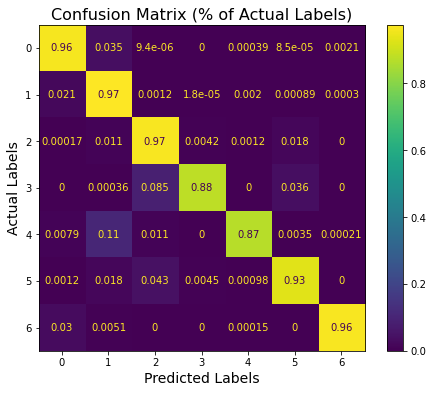

In [13]:
# Cross-validation
cv_score, oof_preds = train_cv(fix_hillshade)

new_rows.append((
    'Fix_Hillshade', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))


Original Train/Test Split

Accuracy: 0.72417
Training Time: 2.13s



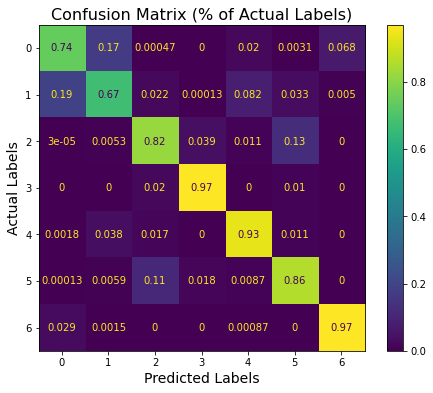

In [14]:
# Train/Test split
test_score, oof_preds = train_original(fix_hillshade)

old_rows.append((
    'Fix_Hillshade', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 4. Water Distance Features

In [15]:
def water_distance_features(data):
    df = data.copy()
    df["Hydro_Taxicab"] = np.abs(df["Horizontal_Distance_To_Hydrology"]) + np.abs(df["Vertical_Distance_To_Hydrology"])
    df["Hydro_Euclid"] = (df["Horizontal_Distance_To_Hydrology"]**2 + df["Vertical_Distance_To_Hydrology"]**2)**0.5
    return df


5-fold Cross-Validation

Fold 0 Accuracy:  0.96457 in 533.04s.
Fold 1 Accuracy:  0.9641 in 514.81s.
Fold 2 Accuracy:  0.96488 in 536.85s.
Fold 3 Accuracy:  0.96417 in 537.66s.
Fold 4 Accuracy:  0.96472 in 595.48s.

Average Accuracy: 0.96449
Worst Accuracy: 0.9641
Training Time: 2717.84s



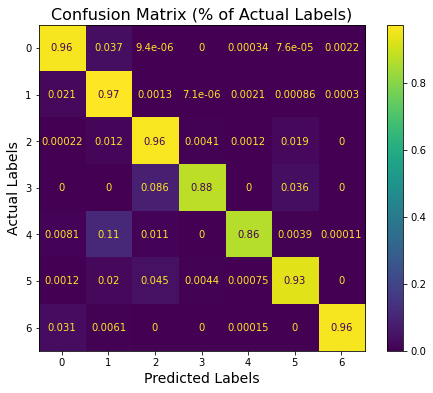

In [16]:
# Cross-validation
cv_score, oof_preds = train_cv(water_distance_features)

new_rows.append((
    'Water_Dist', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))


Original Train/Test Split

Accuracy: 0.71595
Training Time: 2.38s



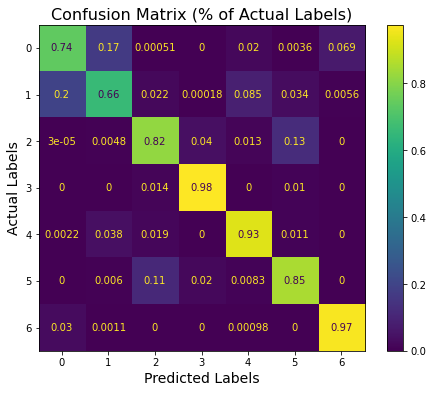

In [17]:
# Train/Test split
test_score, oof_preds = train_original(water_distance_features)

old_rows.append((
    'Water_Dist', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 5. Shade Features

In [18]:
def new_shade_features(data):
    df = data.copy()
    shade_features = ['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']
    df["Hillshade_Avg"] = df[shade_features].mean(axis=1)
    df['Hillshade_Range'] = df[shade_features].max(axis=1) - df[shade_features].min(axis=1)
    return df


5-fold Cross-Validation

Fold 0 Accuracy:  0.96487 in 406.42s.
Fold 1 Accuracy:  0.96443 in 378.39s.
Fold 2 Accuracy:  0.96602 in 423.77s.
Fold 3 Accuracy:  0.96464 in 392.47s.
Fold 4 Accuracy:  0.96551 in 410.1s.

Average Accuracy: 0.9651
Worst Accuracy: 0.96443
Training Time: 2011.15s



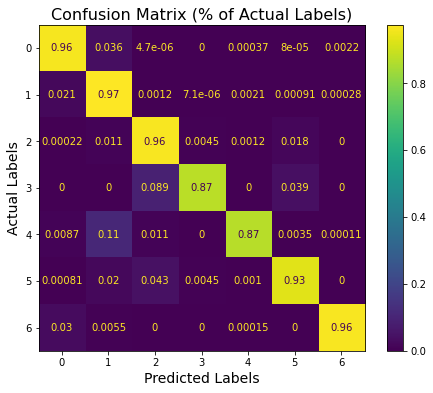

In [19]:
# Cross-validation
cv_score, oof_preds = train_cv(new_shade_features)

new_rows.append((
    'Shade_Features', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))


Original Train/Test Split

Accuracy: 0.71761
Training Time: 2.27s



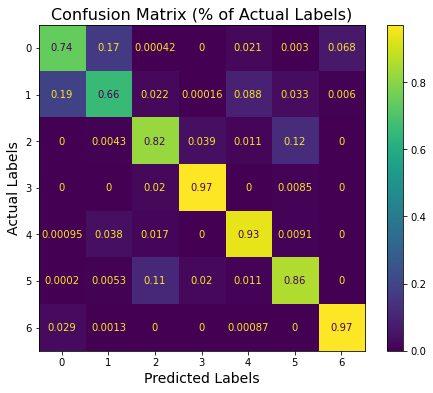

In [20]:
# Train/Test split
test_score, oof_preds = train_original(new_shade_features)

old_rows.append((
    'Shade_Features', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 6. Distance Interactions

In [21]:
def distance_interactions(data):
    df = data.copy()
    df['Hydro_Fire_1'] = df['Horizontal_Distance_To_Hydrology'] + df['Horizontal_Distance_To_Fire_Points']
    df['Hydro_Fire_2'] = abs(df['Horizontal_Distance_To_Hydrology'] - df['Horizontal_Distance_To_Fire_Points'])
    df['Hydro_Road_1'] = abs(df['Horizontal_Distance_To_Hydrology'] + df['Horizontal_Distance_To_Roadways'])
    df['Hydro_Road_2'] = abs(df['Horizontal_Distance_To_Hydrology'] - df['Horizontal_Distance_To_Roadways'])
    df['Fire_Road_1'] = abs(df['Horizontal_Distance_To_Fire_Points'] + df['Horizontal_Distance_To_Roadways'])
    df['Fire_Road_2'] = abs(df['Horizontal_Distance_To_Fire_Points'] - df['Horizontal_Distance_To_Roadways'])
    return df


5-fold Cross-Validation

Fold 0 Accuracy:  0.97275 in 370.15s.
Fold 1 Accuracy:  0.9726 in 333.87s.
Fold 2 Accuracy:  0.97421 in 382.22s.
Fold 3 Accuracy:  0.97274 in 382.01s.
Fold 4 Accuracy:  0.97387 in 347.37s.

Average Accuracy: 0.97323
Worst Accuracy: 0.9726
Training Time: 1815.63s



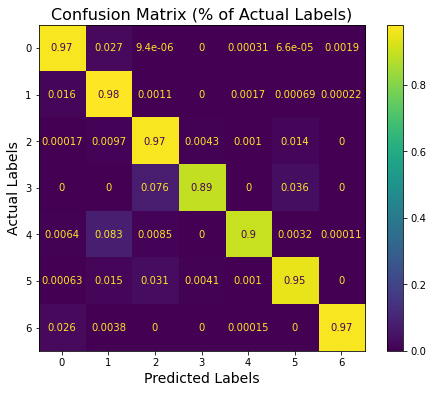

In [22]:
# Cross-validation
cv_score, oof_preds = train_cv(distance_interactions)

new_rows.append((
    'Dist_Interactions', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))


Original Train/Test Split

Accuracy: 0.7471
Training Time: 2.46s



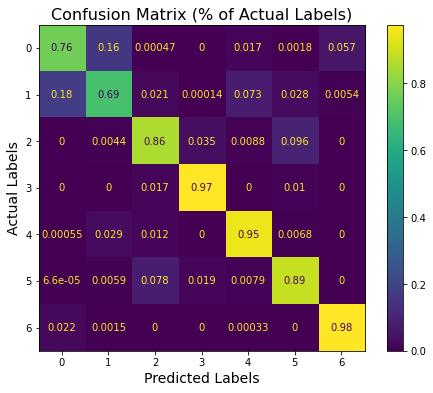

In [23]:
# Train/Test split
test_score, oof_preds = train_original(distance_interactions)

old_rows.append((
    'Dist_Interactions', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 8. Misc. Interactions

In [24]:
def various_interactions(data):
    df = data.copy()
    df['EHiElv'] = df['Horizontal_Distance_To_Roadways'] * df['Elevation']
    df['EViElv'] = df['Vertical_Distance_To_Hydrology'] * df['Elevation']
    df['Highwater'] = (df.Vertical_Distance_To_Hydrology < 0).astype(int)
    df['EVDtH'] = df.Elevation - df.Vertical_Distance_To_Hydrology
    df['EHDtH'] = df.Elevation - df.Horizontal_Distance_To_Hydrology * 0.2
    df['Hillshade_3pm_is_zero'] = (df.Hillshade_3pm == 0).astype(int)
    return df


5-fold Cross-Validation

Fold 0 Accuracy:  0.96591 in 327.57s.
Fold 1 Accuracy:  0.96613 in 390.56s.
Fold 2 Accuracy:  0.96698 in 368.01s.
Fold 3 Accuracy:  0.96541 in 376.98s.
Fold 4 Accuracy:  0.96661 in 379.33s.

Average Accuracy: 0.96621
Worst Accuracy: 0.96541
Training Time: 1842.45s



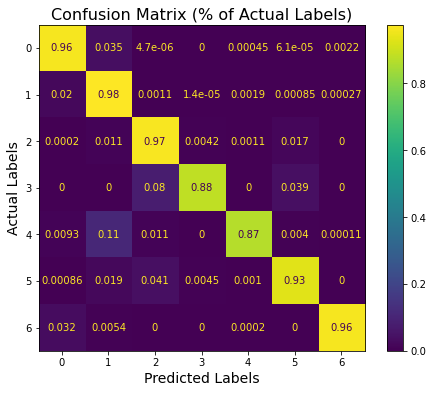

In [25]:
# Cross-validation
cv_score, oof_preds = train_cv(various_interactions)

new_rows.append((
    'Misc_Interactions', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))


Original Train/Test Split

Accuracy: 0.71624
Training Time: 2.39s



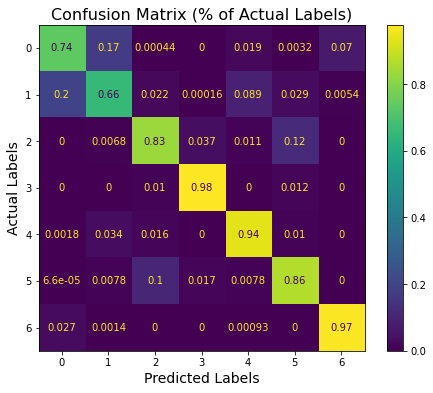

In [26]:
# Train/Test split
test_score, oof_preds = train_original(various_interactions)

old_rows.append((
    'Misc_Interactions', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## Summary 

In [27]:
pd.DataFrame.from_records(
    data = new_rows,
    columns = ['model','cv_scores','recall_0','recall_1','recall_2','recall_3','recall_4','recall_5','recall_6']
).sort_values('cv_scores')

,model,cv_scores,recall_0,recall_1,recall_2,recall_3,recall_4,recall_5,recall_6
3,Water_Dist,0.964486,0.960565,0.974049,0.963165,0.878049,0.864637,0.929522,0.962604
4,Shade_Features,0.965095,0.961428,0.974229,0.964647,0.872588,0.868008,0.930616,0.964115
0,Baseline,0.966021,0.962656,0.974839,0.965207,0.878777,0.870852,0.932055,0.964895
2,Fix_Hillshade,0.966021,0.962656,0.974839,0.965207,0.878777,0.870852,0.932055,0.964895
6,Misc_Interactions,0.966207,0.962354,0.975394,0.966857,0.881325,0.868008,0.933437,0.962555
1,Fix_Aspect,0.966240,0.963048,0.974907,0.964843,0.881689,0.871906,0.933322,0.964798
5,Dist_Interactions,0.973233,0.971091,0.980237,0.970856,0.888606,0.898346,0.947717,0.970356


In [28]:
pd.DataFrame.from_records(
    data = old_rows,
    columns = ['model','accuracy','recall_0','recall_1','recall_2','recall_3','recall_4','recall_5','recall_6']
).sort_values('accuracy')

,model,accuracy,recall_0,recall_1,recall_2,recall_3,recall_4,recall_5,recall_6
3,Water_Dist,0.715946,0.739632,0.656293,0.816252,0.976150,0.930042,0.853489,0.967738
6,Misc_Interactions,0.716241,0.736589,0.656528,0.830302,0.977853,0.938361,0.863287,0.970790
4,Shade_Features,0.717611,0.741306,0.657293,0.822503,0.971039,0.934406,0.856185,0.969373
1,Fix_Aspect,0.719141,0.740142,0.662052,0.817145,0.971039,0.929497,0.855461,0.969319
0,Baseline,0.724172,0.741587,0.670685,0.818902,0.969336,0.932906,0.858486,0.968665
2,Fix_Hillshade,0.724172,0.741587,0.670685,0.818902,0.969336,0.932906,0.858486,0.968665
5,Dist_Interactions,0.747097,0.763015,0.693698,0.856288,0.972743,0.952134,0.889722,0.976076


# Soil Type Features

Next, were going to attempt to leverage domain knowledge to derive further categorical features using the soil types. From the description of the dataset, we have the following:
```
     ID    Code     Description

     1     2702     Cathedral family - Rock outcrop complex, extremely stony.
     2     2703     Vanet - Ratake families complex, very stony.
     3     2704     Haploborolis - Rock outcrop complex, rubbly.
     4     2705     Ratake family - Rock outcrop complex, rubbly.
     5     2706     Vanet family - Rock outcrop complex complex, rubbly.
     6     2717     Vanet - Wetmore families - Rock outcrop complex, stony.
     7     3501     Gothic family.
     8     3502     Supervisor - Limber families complex.
     9     4201     Troutville family, very stony.
    10     4703     Bullwark - Catamount families - Rock outcrop complex, rubbly.
    11     4704     Bullwark - Catamount families - Rock land complex, rubbly.
    12     4744     Legault family - Rock land complex, stony.
    13     4758     Catamount family - Rock land - Bullwark family complex, rubbly.
    14     5101     Pachic Argiborolis - Aquolis complex.
    15     5151     unspecified in the USFS Soil and ELU Survey.
    16     6101     Cryaquolis - Cryoborolis complex.
    17     6102     Gateview family - Cryaquolis complex.
    18     6731     Rogert family, very stony.
    19     7101     Typic Cryaquolis - Borohemists complex.
    20     7102     Typic Cryaquepts - Typic Cryaquolls complex.
    21     7103     Typic Cryaquolls - Leighcan family, till substratum complex.
    22     7201     Leighcan family, till substratum, extremely bouldery.
    23     7202     Leighcan family, till substratum - Typic Cryaquolls complex.
    24     7700     Leighcan family, extremely stony.
    25     7701     Leighcan family, warm, extremely stony.
    26     7702     Granile - Catamount families complex, very stony.
    27     7709     Leighcan family, warm - Rock outcrop complex, extremely stony.
    28     7710     Leighcan family - Rock outcrop complex, extremely stony.
    29     7745     Como - Legault families complex, extremely stony.
    30     7746     Como family - Rock land - Legault family complex, extremely stony.
    31     7755     Leighcan - Catamount families complex, extremely stony.
    32     7756     Catamount family - Rock outcrop - Leighcan family complex, extremely stony.
    33     7757     Leighcan - Catamount families - Rock outcrop complex, extremely stony.
    34     7790     Cryorthents - Rock land complex, extremely stony.
    35     8703     Cryumbrepts - Rock outcrop - Cryaquepts complex.
    36     8707     Bross family - Rock land - Cryumbrepts complex, extremely stony.
    37     8708     Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.
    38     8771     Leighcan - Moran families - Cryaquolls complex, extremely stony.
    39     8772     Moran family - Cryorthents - Leighcan family complex, extremely stony.
    40     8776     Moran family - Cryorthents - Rock land complex, extremely stony.

        Note:   First digit:  climatic zone             Second digit:  geologic zones
                1.  lower montane dry                   1.  alluvium
                2.  lower montane                       2.  glacial
                3.  montane dry                         3.  shale
                4.  montane                             4.  sandstone
                5.  montane dry and montane             5.  mixed sedimentary
                6.  montane and subalpine               6.  unspecified in the USFS ELU Survey
                7.  subalpine                           7.  igneous and metamorphic
                8.  alpine                              8.  volcanic

        The third and fourth ELU digits are unique to the mapping unit 
        and have no special meaning to the climatic or geologic zones.
```

In [29]:
# Dictionary for mapping to ELU Code
code = {
    1:2702,2:2703,3:2704,4:2705,5:2706,
    6:2717,7:3501,8:3502,9:4201,10:4703,
    11:4704,12:4744,13:4758,14:5101,15:5151,
    16:6101,17:6102,18:6731,19:7101,20:7102,
    21:7103,22:7201,23:7202,24:7700,25:7701,
    26:7702,27:7709,28:7710,29:7745,30:7746,
    31:7755,32:7756,33:7757,34:7790,35:8703,
    36:8707,37:8708,38:8771,39:8772,40:8776
}

## 1. Undo One-Hot Encoding

In [30]:
def consolidate_soil_types(input_df, drop = True):
    data = input_df.copy()
    soil_features = sorted([x for x in data.columns if x.startswith("Soil_Type")])
    soil_type = list()
    for index, row in data[soil_features].iterrows():
        found = False
        for i, val in enumerate(row, start = 1):
            if val != 0:
                soil_type.append(i)
                found = True
                break
        if not found: soil_type.append(None)
    data['Soil_Type'] = soil_type
    if drop:
        nonsoil_features = [x for x in data.columns if x not in soil_features]
        return data[nonsoil_features]
    return data
    


5-fold Cross-Validation

Fold 0 Accuracy:  0.96545 in 241.55s.
Fold 1 Accuracy:  0.96521 in 223.83s.
Fold 2 Accuracy:  0.96618 in 242.49s.
Fold 3 Accuracy:  0.96536 in 254.07s.
Fold 4 Accuracy:  0.9655 in 241.72s.

Average Accuracy: 0.96554
Worst Accuracy: 0.96521
Training Time: 1203.66s



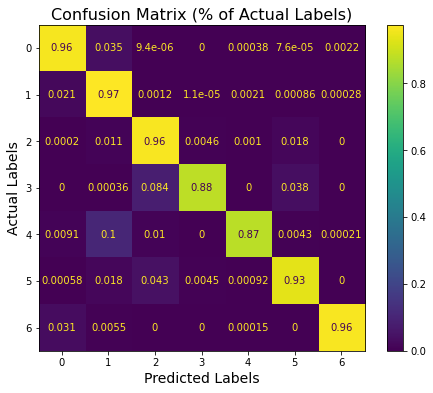

In [31]:
# Cross-validation
cv_score, oof_preds = train_cv(consolidate_soil_types)

new_rows.append((
    'Ordinal_Encoding', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))


Original Train/Test Split

Accuracy: 0.71832
Training Time: 1.51s



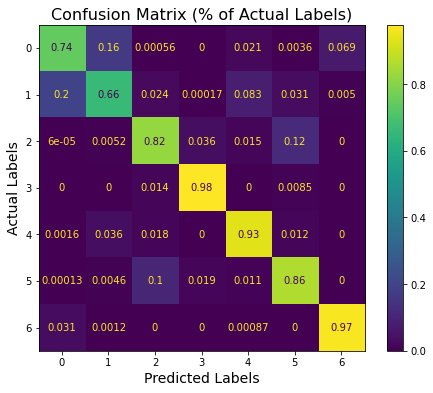

In [32]:
# Train/Test split
test_score, oof_preds = train_original(consolidate_soil_types)

old_rows.append((
    'Ordinal_Encoding', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 2. Climatic Zone

We create a feature based on the climatic zone of the soil, which has a natural ordering:

1. lower montane dry
2. lower montane
3. montane dry
4. montane
5. montane dry and montane
6. montane and subalpine
7. subalpine
8. alpine

However, the ordering of the soil type labels roughly follows the ordering of their respectively climatic zones, so there's a chance this feature won't be particularly informative.

In [33]:
def climatic_zone_original(input_df):
    data = input_df.copy()
    data = consolidate_soil_types(data, drop = False)
    data['Climatic Zone'] = data['Soil_Type'].apply(lambda x: int(str(code[x])[0]))
    return data


5-fold Cross-Validation

Fold 0 Accuracy:  0.96651 in 372.37s.
Fold 1 Accuracy:  0.96541 in 368.32s.
Fold 2 Accuracy:  0.96685 in 399.93s.
Fold 3 Accuracy:  0.96564 in 385.48s.
Fold 4 Accuracy:  0.96652 in 394.67s.

Average Accuracy: 0.96619
Worst Accuracy: 0.96541
Training Time: 1920.75s



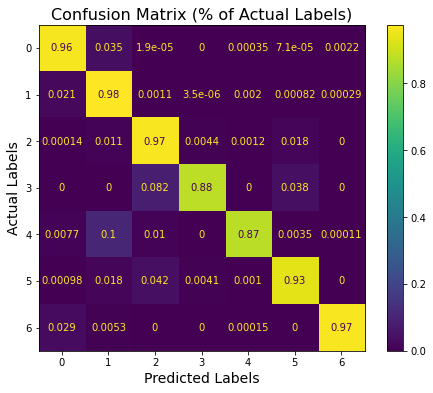

In [34]:
# Cross-validation
cv_score, oof_preds = train_cv(climatic_zone_original)

new_rows.append((
    'Climatic_Zone', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))


Original Train/Test Split

Accuracy: 0.72123
Training Time: 2.06s



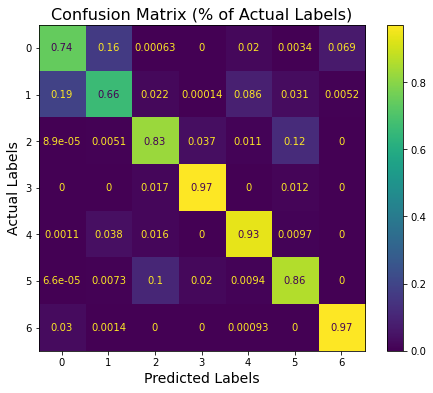

In [35]:
# Train/Test split
test_score, oof_preds = train_original(climatic_zone_original)

old_rows.append((
    'Climatic_Zone', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 3. Geologic Zones

1. alluvium
2. glacial
3. shale
4. sandstone
5. mixed sedimentary
6. unspecified in the USFS ELU Survey
7. igneous and metamorphic
8. volcanic

This is another feature which is based on the soil type codes.

In [36]:
def geologic_zone_original(input_df):
    data = input_df.copy()
    data = consolidate_soil_types(data, drop = False)
    data['Geologic_Zone'] = data['Soil_Type'].apply(lambda x: int(str(code[x])[1]))
    return data


5-fold Cross-Validation

Fold 0 Accuracy:  0.96602 in 406.6s.
Fold 1 Accuracy:  0.96609 in 394.94s.
Fold 2 Accuracy:  0.96688 in 361.0s.
Fold 3 Accuracy:  0.96611 in 423.73s.
Fold 4 Accuracy:  0.9664 in 395.39s.

Average Accuracy: 0.9663
Worst Accuracy: 0.96602
Training Time: 1981.66s



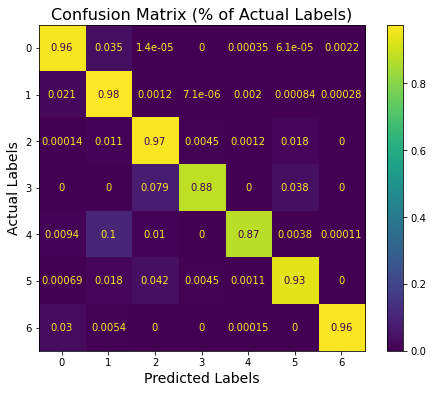

In [37]:
# Cross-validation
cv_score, oof_preds = train_cv(geologic_zone_original)

new_rows.append((
    'Geologic_Zone', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))


Original Train/Test Split

Accuracy: 0.72226
Training Time: 2.1s



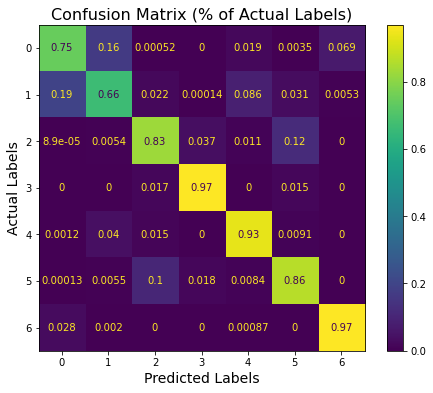

In [38]:
# Train/Test split
test_score, oof_preds = train_original(geologic_zone_original)

old_rows.append((
    'Geologic_Zone', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 4. Surface Cover

According to the [USDA reference](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/soils/ref/?cid=nrcs142p2_054253#surface_fragments) on soil profiling:

1. **(Stony/Bouldery)** — Stones or boulders cover 0.01 to less than 0.1 percent of the surface. The smallest stones are at least 8 meters apart; the smallest boulders are at least 20 meters apart (fig. 3-9).

2. **(Very Stony/Very Bouldery)** — Stones or boulders cover 0.1 to less than 3 percent of the surface. The smallest stones are not less than 1 meter apart; the smallest boulders are not less than 3 meters apart (fig. 3-10).

3. **(Extremely Stony/Extremely Bouldery)** — Stones or boulders cover 3 to less than 15 percent of the surface. The smallest stones are as little as 0.5 meter apart; the smallest boulders are as little as 1 meter apart (fig. 3-11).

4. **(Rubbly)** — Stones or boulders cover 15 to less than 50 percent of the surface. The smallest stones are as little as 0.3 meter apart; the smallest boulders are as little as 0.5 meter apart. In most places it is possible to step from stone to stone or jump from boulder to boulder without touching the soil (fig. 3-12).

5. **(Very Rubbly)** — Stones or boulders appear to be nearly continuous and cover 50 percent or more of the surface. The smallest stones are less than 0.03 meter apart; the smallest boulders are less than 0.05 meter apart. Classifiable soil is among the rock fragments, and plant growth is possible (fig. 3-13).

In [39]:
# Group IDs
no_desc = [7,8,14,15,16,17,19,20,21,23,35]
stony = [6,12]
very_stony = [2,9,18,26]
extremely_stony = [1,22,24,25,27,28,29,30,31,32,33,34,36,37,38,39,40]
rubbly = [3,4,5,10,11,13]

# Create dictionary
surface_cover = {i:None for i in no_desc}
surface_cover.update({i:0 for i in stony})
surface_cover.update({i:1 for i in very_stony})
surface_cover.update({i:2 for i in extremely_stony})
surface_cover.update({i:3 for i in rubbly})

# Preprocessing function
def surface_cover_original(input_df):
    data = input_df.copy()
    data = consolidate_soil_types(data, drop = False)
    data['Surface_Cover'] = data['Soil_Type'].apply(lambda x: surface_cover[x])
    return data


5-fold Cross-Validation

Fold 0 Accuracy:  0.96613 in 569.5s.
Fold 1 Accuracy:  0.96563 in 532.28s.
Fold 2 Accuracy:  0.96645 in 532.53s.
Fold 3 Accuracy:  0.96556 in 544.7s.
Fold 4 Accuracy:  0.96612 in 564.27s.

Average Accuracy: 0.96598
Worst Accuracy: 0.96556
Training Time: 2743.28s



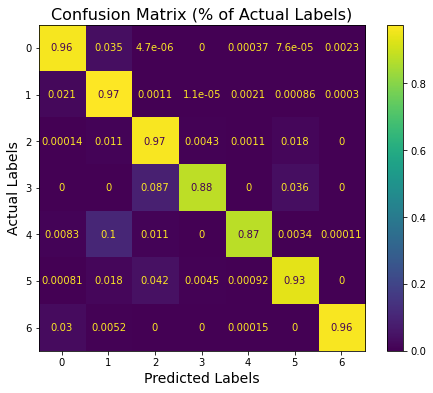

In [40]:
# Cross-validation
cv_score, oof_preds = train_cv(surface_cover_original)

new_rows.append((
    'Surface_Cover', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))


Original Train/Test Split

Accuracy: 0.72193
Training Time: 2.13s



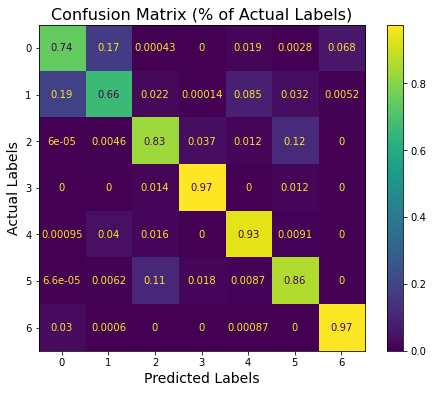

In [41]:
# Train/Test split
test_score, oof_preds = train_original(surface_cover_original)

old_rows.append((
    'Surface_Cover', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 5. Rock Size (Ordinal)

According to the [USDA reference](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/soils/ref/?cid=nrcs142p2_054253#fragments) on soil profile:

* Stones/Stony - 250–600 mm diameter
* Boulders/Bouldery - > 600 mm diameter

We can use these to perhaps derive useful features

In [42]:
# Group IDs
no_desc = [7,8,14,15,16,17,19,20,21,23,35]
stones = [1,2,6,9,12,18,24,25,26,27,28,29,30,31,32,33,34,36,37,38,39,40]
boulders = [22]
rubble = [3,4,5,10,11,13]

# Create dictionary
rock_size = {i:None for i in no_desc}
rock_size.update({i:0 for i in stones})
rock_size.update({i:1 for i in boulders})
rock_size.update({i:2 for i in rubble})

# Preprocessing function
def rock_size_original(input_df):
    data = input_df.copy()
    data = consolidate_soil_types(data, drop = False)
    data['Rock_Size'] = data['Soil_Type'].apply(lambda x: rock_size[x])
    return data


5-fold Cross-Validation

Fold 0 Accuracy:  0.96646 in 560.88s.
Fold 1 Accuracy:  0.96504 in 500.5s.
Fold 2 Accuracy:  0.96695 in 515.46s.
Fold 3 Accuracy:  0.96557 in 491.52s.
Fold 4 Accuracy:  0.96645 in 528.79s.

Average Accuracy: 0.96609
Worst Accuracy: 0.96504
Training Time: 2597.15s



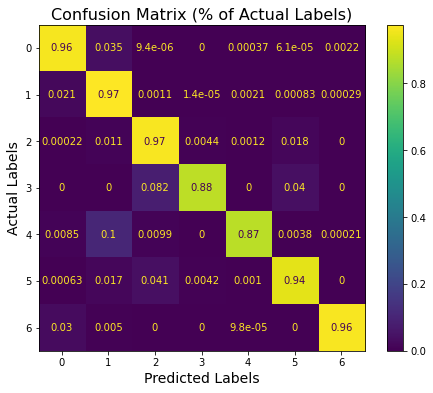

In [43]:
# Cross-validation
cv_score, oof_preds = train_cv(rock_size_original)

new_rows.append((
    'Rock_Size', cv_score,
     *recall_score(original['Cover_Type'], oof_preds, average = None)
))


Original Train/Test Split

Accuracy: 0.72213
Training Time: 2.01s



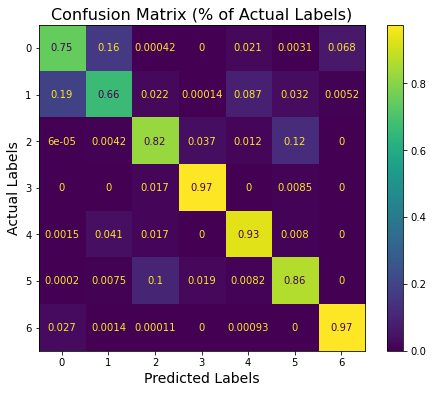

In [44]:
# Train/Test split
test_score, oof_preds = train_original(rock_size_original)

old_rows.append((
    'Rock_Size', test_score,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 6. More Description Features

I may do something with this in the future...

In [45]:
families = dict(
    cathedral = [1],
    rock_outcrop = [1,3,4,5,6,10,27,28,32,33,35,37],
    rock_land = [11,12,13,30,34,40],
    vanet = [2,5,6],
    ratake = [2,4],
    wetmore = [6],
    haploborolis = [3],
    gothic = [7],
    supervisor = [8],
    limber = [8],
    troutville = [9],
    bullwark = [10,11,13],
    legault = [12],
    pachic_argiborolis = [14],
    aquolis = [14],
    unspecified = [15],
    cryoborolis = [16],
    cryaquolis = [16,17,19],
    borohmists = [19],
    cryaquepts = [20,35],
    cryaquolls = [20,21,23,38],
    cryorthents = [34,37,39,40],
    cryumbrepts = [35,36,37],
    gateview = [17],
    rogert = [18],
    till_substratum = [21,22,23],
    granile = [26],
    catamount = [26,10,11,13,26,31,32,33],
    leighcan = [21,22,23,24,25,27,28,29,31,32,33,38,39],
    como = [29,30],
    bross = [36],
    moran = [38,39,40],
)

# Summary

In [46]:
pd.DataFrame.from_records(
    data = new_rows,
    columns = ['features','cv_scores','recall_0', 'recall_1','recall_2','recall_3','recall_4','recall_5','recall_6']
).sort_values('cv_scores')

,features,cv_scores,recall_0,recall_1,recall_2,recall_3,recall_4,recall_5,recall_6
3,Water_Dist,0.964486,0.960565,0.974049,0.963165,0.878049,0.864637,0.929522,0.962604
4,Shade_Features,0.965095,0.961428,0.974229,0.964647,0.872588,0.868008,0.930616,0.964115
7,Ordinal_Encoding,0.965539,0.961976,0.974366,0.964955,0.878049,0.872748,0.933322,0.963384
10,Surface_Cover,0.965978,0.962273,0.974889,0.965263,0.876957,0.873591,0.933610,0.964505
0,Baseline,0.966021,0.962656,0.974839,0.965207,0.878777,0.870852,0.932055,0.964895
2,Fix_Hillshade,0.966021,0.962656,0.974839,0.965207,0.878777,0.870852,0.932055,0.964895
11,Rock_Size,0.966092,0.962547,0.974716,0.965375,0.878049,0.873170,0.936143,0.964993
8,Climatic_Zone,0.966187,0.962387,0.975101,0.965319,0.879869,0.874223,0.933955,0.965236
6,Misc_Interactions,0.966207,0.962354,0.975394,0.966857,0.881325,0.868008,0.933437,0.962555
1,Fix_Aspect,0.966240,0.963048,0.974907,0.964843,0.881689,0.871906,0.933322,0.964798


In [47]:
pd.DataFrame.from_records(
    data = old_rows,
    columns = ['features','accuracy','recall_0', 'recall_1','recall_2','recall_3','recall_4','recall_5','recall_6']
).sort_values('accuracy')

,features,accuracy,recall_0,recall_1,recall_2,recall_3,recall_4,recall_5,recall_6
3,Water_Dist,0.715946,0.739632,0.656293,0.816252,0.976150,0.930042,0.853489,0.967738
6,Misc_Interactions,0.716241,0.736589,0.656528,0.830302,0.977853,0.938361,0.863287,0.970790
4,Shade_Features,0.717611,0.741306,0.657293,0.822503,0.971039,0.934406,0.856185,0.969373
7,Ordinal_Encoding,0.718321,0.741625,0.658396,0.823128,0.977853,0.932361,0.860459,0.966649
1,Fix_Aspect,0.719141,0.740142,0.662052,0.817145,0.971039,0.929497,0.855461,0.969319
8,Climatic_Zone,0.721232,0.742565,0.662991,0.826700,0.971039,0.934679,0.860525,0.967956
10,Surface_Cover,0.721930,0.741377,0.664930,0.830957,0.974446,0.933588,0.857105,0.968719
11,Rock_Size,0.722126,0.745493,0.662717,0.823783,0.974446,0.932088,0.862563,0.970845
9,Geologic_Zone,0.722262,0.745059,0.662749,0.828278,0.967632,0.934270,0.864602,0.968937
0,Baseline,0.724172,0.741587,0.670685,0.818902,0.969336,0.932906,0.858486,0.968665
